In [150]:
# SETUP -------------------------------------------------------------------------------------------------------------

In [175]:
import pandas as pd
import xlrd
import numpy as np
import os
import miceforest as mf
from imblearn.over_sampling import SMOTE
from pathlib import Path

pd.set_option('display.max_columns', None)
print("done")

done


In [152]:
def mode_func(series):
    return series.mode().iloc[0] if not series.mode().empty else None

In [ ]:
# Load Data -------------------------------------------------------------------------------------------------------------

In [183]:
# **Define your project base directory**
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    root_dir = current_dir.parent
else:
    root_dir = current_dir

# Define your paths based on the 'root_dir'
data_path = root_dir / "Data"

print(f"Data loading from: {data_path}")

Data loading from: /Users/ethanshiu/Documents/GitHub/25-spring-ESHIU/Data


In [176]:
file_path = data_path / "NAVCO2-1_ForPublication.xls"

In [177]:
pop_path = data_path / "population.csv"

In [178]:
code_path = data_path / "countries-codes.csv"

In [179]:
# Population DataFrame

In [180]:
df_pop = pd.read_csv(pop_path)
df_pop.columns = df_pop.columns.str.lower()
print(df_pop.head(5))

        entity code   year  population_historical
0  Afghanistan  AFG -10000                  14737
1  Afghanistan  AFG  -9000                  20405
2  Afghanistan  AFG  -8000                  28253
3  Afghanistan  AFG  -7000                  39120
4  Afghanistan  AFG  -6000                  54166


In [181]:
# Filter needed years
df_pop = df_pop[df_pop["year"] >= 1940]
df_pop.rename(columns={"code":"iso3_code"}, inplace=True)
print(df_pop.head(5))

          entity iso3_code  year  population_historical
177  Afghanistan       AFG  1940                6468510
178  Afghanistan       AFG  1941                6528377
179  Afghanistan       AFG  1942                6608815
180  Afghanistan       AFG  1943                6710138
181  Afghanistan       AFG  1944                6813016


In [173]:
# ISO3 country codes for merging 

In [174]:
df_cc = pd.read_csv(code_path, delimiter=";", encoding="latin1", usecols=["ONU CODE", "ISO3 CODE", "LABEL EN"])
df_cc.columns = df_cc.columns.str.lower().str.replace(" ", "_")
df_cc.rename(columns={"onu_code": "loc_iso"}, inplace=True)

print(df_cc.head(5))

  iso3_code  loc_iso        label_en
0       KHM      116        Cambodia
1       CHE      756     Switzerland
2       NGA      566         Nigeria
3       CZE      203  Czech Republic
4       UZB      860      Uzbekistan


In [136]:
#DF Full for Initial Feature Selection

In [137]:
df_full = pd.read_excel(file_path)

# Drop unneeded columns
columns_to_drop = [
    "status", "pop_opinion", "audience_backlash", "campyearid", "camp_name",
    "target", "loc_cow", "loc_vdem", "territory", "terr_iso", "terr_cow", "terr_vdem",
    "target_country", "targ_iso", "targ_cow", "targ_vdem", "start_date", "start_year",
    "start_date_source", "end_date", "end_year", "end_date_source", "camp_orgs_list",
    "cdivers_types", "parall_instit_types", "fatalities_high_source", "fatalities_low_source",
    "fatalities_range_source", "reliability", "coding_notes", "ra_initials", "tccode",
    "start_date_obsolete", "end_date_obsolete", "lccode"
]
df_full = df_full.drop(columns=columns_to_drop, axis=1)

In [138]:
#df_full = pd.read_excel(file_path).drop(["status", "pop_opinion", "audience_backlash", "campyearid","camp_name","target","loc_cow","loc_vdem", "territory", "terr_iso", "terr_cow", "terr_vdem", "target_country", "targ_iso", "targ_cow", "targ_vdem", "start_date", "start_year", "start_date_source", "end_date", "end_year", "end_date_source", "camp_orgs_list", "cdivers_types", "parall_instit_types", "fatalities_high_source", "fatalities_low_source", "fatalities_range_source", "reliability", "coding_notes", "ra_initials", "tccode", "start_date_obsolete", "end_date_obsolete", "lccode"], axis=1)

In [139]:
df_full = df_full.drop(columns=[col for col in df_full.columns if "_ref" in col])

In [140]:
df_full.columns

Index(['id', 'year', 'location', 'loc_iso', 'navco1_desig', 'cyear',
       'camp_beyear', 'camp_duration', 'prim_meth', 'resis_meth', 'camp_goals',
       'goalschange', 'camp_orgs', 'camp_size', 'camp_size_cat',
       'camp_size_n2', 'camp_size_cat_n2', 'total_part',
       'camp_confl_intensity', 'violent_flank', 'flank_intensity',
       'flank_scope', 'flank_response', 'camp_structure', 'media_outreach',
       'cdivers', 'div_gender', 'div_age', 'div_class', 'div_urban_rural',
       'div_ideology', 'div_party', 'div_regional', 'div_ethnicity',
       'div_religion', 'parall_instit', 'pi_education', 'pi_soc_welfare',
       'pi_trad_media', 'pi_new_media', 'pi_police', 'pi_armed_wing',
       'pi_courts', 'pi_pol_party', 'pi_pol_wing', 'pi_nv_mobiliz',
       'repression', 'indiscrim', 'fatalities_high', 'fatalities_low',
       'fatalities_range', 'ab_domestic', 'ab_internat', 'ab_int_mat',
       'camp_backlash', 'sec_defect', 'state_defect', 'regime_support',
       'reg_supp

In [141]:
# Replace -99 unknown values with NA
df_full.replace(-99, np.nan, inplace=True)
df_full.replace("-99", np.nan, inplace=True)

In [142]:
# Check NA value counts
na_counts = df_full.isna().sum()
na_counts = na_counts[na_counts > 100]  # Filters only columns with NaNs
pd.set_option("display.max_rows", None)
print(na_counts)

navco1_desig         721
camp_size            260
camp_size_cat        236
camp_size_n2         966
camp_size_cat_n2     947
total_part           429
flank_intensity     2218
flank_scope         2214
flank_response      2303
fatalities_high      907
fatalities_low       679
fatalities_range     412
ab_domestic          458
ab_internat          458
ab_int_mat           458
sec_defect           258
state_defect         178
regime_support       139
reg_supporter1      1454
reg_supporter2      2167
reg_supporter3      2440
wdrwl_support        207
camp_supporter1     1411
camp_supporter2     2102
camp_supporter3     2409
ingo_support         136
dias_support         136
dom_media            444
dtype: int64


In [143]:
# Determine which columns have too many missing values
missing_percent = df_full.isna().sum() / len(df_full) * 100
missing_percent = missing_percent[missing_percent > 20].index.to_list()
print(missing_percent)

['navco1_desig', 'camp_size_n2', 'camp_size_cat_n2', 'flank_intensity', 'flank_scope', 'flank_response', 'fatalities_high', 'fatalities_low', 'reg_supporter1', 'reg_supporter2', 'reg_supporter3', 'camp_supporter1', 'camp_supporter2', 'camp_supporter3']


In [144]:
df_feature_select = df_full.drop(columns=missing_percent)
print(df_feature_select.sample(10))

       id  year  location  loc_iso  cyear  camp_beyear  camp_duration  \
279    73  1977     Spain    724.0      1            0             46   
2433  386  1992   Senegal    686.0      1            0             32   
1714  237  1995    Angola     24.0      1            0             28   
278    73  1976     Spain    724.0      1            0             46   
606   115  1996     India    356.0      1            0             24   
2390  382  1998  Ethiopia    231.0      1            0             21   
1181  175  1967      Oman    512.0      1            0             13   
1185  175  1971      Oman    512.0      1            0             13   
469    97  1973        UK    826.0      1            0             31   
1631  228  1959     Tibet    156.0      2            0              4   

      prim_meth  resis_meth  camp_goals  goalschange  camp_orgs  camp_size  \
279           0           0         3.0          0.0        0.0        2.0   
2433          0           0         3.0 

In [145]:
# Check if there are any remaining missing / Unknown values
count_neg_99 = ((df_feature_select == -99) | (df_feature_select == "-99")).sum().sum()
count_neg_99_sub = df_feature_select.astype(str).apply(lambda x: x.str.contains("-99", na=False)).sum().sum()

print(f"Total occurrences of '-99' (as substring): {count_neg_99_sub}")
print(f"Total occurrences of '-99' (as number or string): {count_neg_99}")


Total occurrences of '-99' (as substring): 0
Total occurrences of '-99' (as number or string): 0


In [146]:
# MERGE
print(df_feature_select.sample(10))

       id  year       location  loc_iso  cyear  camp_beyear  camp_duration  \
2577  406  1986  Myanmar/Burma    104.0      1            0             27   
416    87  1995      Indonesia    360.0      1            0             30   
1344  188  1975        Namibia    516.0      1            0             29   
461    95  1989        Hungary    348.0      0            1              1   
1844  251  2001         Turkey    792.0      1            0             36   
775   131  1952       Malaysia    458.0      1            0             13   
2085  347  1980          India    356.0      0            0             34   
483    97  1987             UK    826.0      1            0             31   
1077  160  1969  Guinea-Bissau    624.0      1            0             12   
279    73  1977          Spain    724.0      1            0             46   

      prim_meth  resis_meth  camp_goals  goalschange  camp_orgs  camp_size  \
2577          0           0         0.0          0.0        0.0

In [147]:
# Merge population data into the navco dataset
#print(df_feature_select.sample(10))
# Modify for Discrepancies
df_feature_select.loc[df_feature_select["location"] == "South Vietnam", "loc_iso"] = 704.0
df_feature_select.loc[df_feature_select["location"] == "Palestine", "loc_iso"] = 376.0
df_feature_select.loc[df_feature_select["location"] == "Russia", "loc_iso"] = 643.0
df_feature_select.loc[df_feature_select["location"] == "Serbia", "loc_iso"] = 891.0
df_cc.loc[df_cc["iso3_code"] == "CS1", "iso3_code"] = "OWID_CZS"
df_cc.loc[df_cc["iso3_code"] == "DE1", "iso3_code"] = "OWID_GDR"
df_cc.loc[df_cc["iso3_code"] == "SCG", "iso3_code"] = "OWID_SRM"
df_cc.loc[df_cc["iso3_code"] == "YU1", "iso3_code"] = "OWID_YGS"
#df_cc.loc[df_cc["iso3_code"] == "YE1", "iso3_code"] = "OWID_YAR"
df_cc.loc[df_cc["iso3_code"] == "YE2", "iso3_code"] = "OWID_YPR"
df_cc.loc[df_cc["iso3_code"] == "URS", "iso3_code"] = "OWID_USS"



# Merge pop with navco
navco_cc = df_feature_select.merge(df_cc, on="loc_iso", how="left")
print(navco_cc[navco_cc["iso3_code"].isna()][["location", "loc_iso", "iso3_code", "label_en"]])

Empty DataFrame
Columns: [location, loc_iso, iso3_code, label_en]
Index: []


In [148]:
df_full = navco_cc.merge(df_pop, on=["iso3_code", "year"], how="left")
#print(df_full[df_full["location"].str.contains("Yemen")])
df_full.dropna(subset=["population_historical"], inplace=True)
print(
    df_full[df_full["population_historical"].isna()][
        ["year", "location", "loc_iso", "iso3_code", "label_en", "entity", "population_historical"]
    ]
)


Empty DataFrame
Columns: [year, location, loc_iso, iso3_code, label_en, entity, population_historical]
Index: []


In [25]:
# Check NA value counts
na_counts_2 = df_full.isna().sum()
na_counts_2 = na_counts_2[na_counts_2 > 100]  # Filters only columns with NaNs
pd.set_option("display.max_rows", None)
print(na_counts_2)

camp_size           252
camp_size_cat       228
total_part          420
fatalities_range    410
ab_domestic         453
ab_internat         453
ab_int_mat          453
sec_defect          254
state_defect        174
regime_support      139
wdrwl_support       207
ingo_support        136
dias_support        136
dom_media           444
dtype: int64


In [26]:
# Drop columns from merge
print(df_full.columns)
df_full = df_full.drop(columns=["location", "loc_iso", "iso3_code", "label_en", "entity"])
print(df_full.sample(10))

Index(['id', 'year', 'location', 'loc_iso', 'cyear', 'camp_beyear',
       'camp_duration', 'prim_meth', 'resis_meth', 'camp_goals', 'goalschange',
       'camp_orgs', 'camp_size', 'camp_size_cat', 'total_part',
       'camp_confl_intensity', 'violent_flank', 'camp_structure',
       'media_outreach', 'cdivers', 'div_gender', 'div_age', 'div_class',
       'div_urban_rural', 'div_ideology', 'div_party', 'div_regional',
       'div_ethnicity', 'div_religion', 'parall_instit', 'pi_education',
       'pi_soc_welfare', 'pi_trad_media', 'pi_new_media', 'pi_police',
       'pi_armed_wing', 'pi_courts', 'pi_pol_party', 'pi_pol_wing',
       'pi_nv_mobiliz', 'repression', 'indiscrim', 'fatalities_range',
       'ab_domestic', 'ab_internat', 'ab_int_mat', 'camp_backlash',
       'sec_defect', 'state_defect', 'regime_support', 'wdrwl_support',
       'camp_support', 'ingo_support', 'dias_support', 'sdirect', 'slifted',
       'in_media', 'dom_media', 'success', 'progress', 'iso3_code', 'label_en

In [27]:
#MICE - FEATURE SELECT -------------------------------------------------------------------------------------------------------------

In [28]:
#print(df_feature_select.dtypes)
object_cols = df_full.select_dtypes(include=['object']).columns
print("Object columns:", object_cols)
df_full = df_full.reset_index(drop=True)


Object columns: Index([], dtype='object')


In [29]:
# Columns for MICE

kernel = mf.ImputationKernel(
    data=df_full,
    random_state=42  # Optional: for reproducibility
)


# Perform 3 iterations of MICE
kernel.mice(iterations=3, n_jobs=-1)

# Retrieve the completed dataset
completed_data = kernel.complete_data()

df1_uncollapsed = completed_data

print(completed_data.sample(5))

       id  year  cyear  camp_beyear  camp_duration  prim_meth  resis_meth  \
636   117  1968      1            0             16          0           0   
470    97  1976      1            0             31          0           0   
1494  208  1983      1            0             10          0           0   
1858  258  2008      1            0             10          0           0   
1887  278  1986      0            1              1          1           0   

      camp_goals  goalschange  camp_orgs  camp_size  camp_size_cat  \
636          0.0          0.0        1.0        2.0            1.0   
470          3.0          0.0        0.0        0.0            0.0   
1494         0.0          0.0        0.0        1.0            0.0   
1858         4.0          0.0        0.0        3.0            0.0   
1887         0.0          0.0        2.0        3.0            2.0   

      total_part  camp_confl_intensity  violent_flank  camp_structure  \
636      25000.0                   1.0     

In [30]:
na_counts = df1_uncollapsed.isna().sum()
na_counts = na_counts[na_counts > 100]  # Filters only columns with NaNs
pd.set_option("display.max_rows", None)
print(na_counts)

Series([], dtype: int64)


In [31]:
# FEATURE ENGINEERING -------------------------------------------------------------------------------------------------------------

In [32]:
# Relative Participation 
df1_uncollapsed["rel_part"] = df1_uncollapsed["total_part"] / df1_uncollapsed["population_historical"]
print(df1_uncollapsed.sample(10))

       id  year  cyear  camp_beyear  camp_duration  prim_meth  resis_meth  \
15      3  1987      1            0             10          0           0   
2150  351  2005      1            0             29          0           0   
2411  386  1987      1            0             32          0           0   
614   115  2006      1            0             24          0           0   
1234  182  1968      1            0             50          0           0   
1516  210  1963      2            0             12          0           0   
2661  413  1962      1            0              5          0           0   
1212  180  1999      1            0             12          0           0   
401    87  1982      1            0             30          0           0   
1227  181  1990      1            0             14          0           0   

      camp_goals  goalschange  camp_orgs  camp_size  camp_size_cat  \
15           5.0          0.0        0.0        2.0            1.0   
2150        

In [33]:
# Check Distribution
print(df1_uncollapsed["rel_part"].describe())

count    2.696000e+03
mean     8.003485e-03
std      5.026716e-02
min      1.156106e-07
25%      4.248035e-05
50%      3.651087e-04
75%      2.063230e-03
max      1.275844e+00
Name: rel_part, dtype: float64


In [34]:
# Check for Outliers
df1_uncollapsed[df1_uncollapsed["rel_part"] > 1]

,id,year,cyear,camp_beyear,camp_duration,prim_meth,resis_meth,camp_goals,goalschange,camp_orgs,camp_size,camp_size_cat,total_part,camp_confl_intensity,violent_flank,camp_structure,media_outreach,cdivers,div_gender,div_age,div_class,div_urban_rural,div_ideology,div_party,div_regional,div_ethnicity,div_religion,parall_instit,pi_education,pi_soc_welfare,pi_trad_media,pi_new_media,pi_police,pi_armed_wing,pi_courts,pi_pol_party,pi_pol_wing,pi_nv_mobiliz,repression,indiscrim,fatalities_range,ab_domestic,ab_internat,ab_int_mat,camp_backlash,sec_defect,state_defect,regime_support,wdrwl_support,camp_support,ingo_support,dias_support,sdirect,slifted,in_media,dom_media,success,progress,population_historical,rel_part
1471,202,1989,1,0,5,1,0,3.0,1.0,2.0,5.0,3.0,2000000.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0,3,1567590.0,1.275844


In [35]:
df1_uncollapsed["log_rel_part"] = np.log1p(df1_uncollapsed["rel_part"])
print(df1_uncollapsed.sample(10))

       id  year  cyear  camp_beyear  camp_duration  prim_meth  resis_meth  \
1206  180  1993      1            0             12          0           0   
2188  354  2006      1            0             10          0           0   
1286  186  1959      1            0              6          0           0   
1353  191  1980      1            0             16          0           1   
1290  187  1984      1            0             23          0           0   
1909  292  1990      2            0              2          1           0   
401    87  1982      1            0             30          0           0   
1277  182  2011      1            0             50          0           0   
225    58  1948      0            0              4          1           0   
1306  187  2000      1            0             23          0           0   

      camp_goals  goalschange  camp_orgs  camp_size  camp_size_cat  \
1206         0.0          0.0        0.0        1.0            0.0   
2188        

In [36]:
# REMOVE OUTLIERS -------------------------------------------------------------------------------------------------------------

In [37]:
# Cap log_rel_part at the 95th percentile
cap_value = df1_uncollapsed['log_rel_part'].quantile(0.95)
df1_uncollapsed['log_rel_part'] = np.minimum(df1_uncollapsed['log_rel_part'], cap_value)


In [38]:
# Cap extreme values in total_part using the 99th percentile
cap_threshold_tp = df1_uncollapsed["total_part"].quantile(0.95)
df1_uncollapsed["total_part_capped"] = df1_uncollapsed["total_part"].clip(upper=cap_threshold_tp)


In [39]:
agg_rules = {
    "id": "first",
    "success": "max",
    "year": "min",
    "camp_duration": "max",
    "camp_size": "mean",
    "fatalities_range": "max",
    "violent_flank": "max",
    "prim_meth": mode_func,
    "camp_goals": "max",
    "camp_structure": mode_func,
    "repression": "max",
    "indiscrim": "max",
    "camp_backlash": "max",
    "regime_support": "max",
    "camp_support": "max",
    "ingo_support": "max",
    "in_media": "max",
    "dom_media": "max",
    "media_outreach": "mean",
    "sec_defect": "max",
    "state_defect": "max",
    "sdirect": "max",
    "wdrwl_support": "max",
    "log_rel_part": "mean",
    "total_part": "mean",
    "pi_pol_party": "max",
    "ab_internat": "max",
    "div_class": mode_func,
    "div_ethnicity": mode_func,
    "camp_orgs": "max"
}


df_collapsed = df1_uncollapsed.groupby("id").agg(agg_rules)
print(df_collapsed.sample(10))

      id  success  year  camp_duration  camp_size  fatalities_range  \
id                                                                    
228  228        0  1956              4   1.750000               6.0   
272  272        1  2009              1   2.000000               3.0   
260  260        0  2011              1   2.000000               0.0   
255  255        0  2011              3   2.333333               3.0   
283  283        1  2007              1   2.000000               0.0   
355  355        0  1948              5   1.800000               5.0   
57    57        1  1980             11   1.545455               5.0   
332  332        1  2007              7   1.714286               0.0   
147  147        0  1996              1   2.000000               2.0   
312  312        0  2013              1   2.000000               1.0   

     violent_flank  prim_meth  camp_goals  camp_structure  repression  \
id                                                                      
2

In [40]:
# Check for duplicates in the 'id' column to see if all campaigns are collapsed
duplicates = df_collapsed[df_collapsed.duplicated(subset="id", keep=False)]

# Print the number of duplicates and optionally the rows themselves
print(f"Number of duplicate 'id' values: {duplicates.shape[0]}")
print(duplicates)


Number of duplicate 'id' values: 0
Empty DataFrame
Columns: [id, success, year, camp_duration, camp_size, fatalities_range, violent_flank, prim_meth, camp_goals, camp_structure, repression, indiscrim, camp_backlash, regime_support, camp_support, ingo_support, in_media, dom_media, media_outreach, sec_defect, state_defect, sdirect, wdrwl_support, log_rel_part, total_part, pi_pol_party, ab_internat, div_class, div_ethnicity, camp_orgs]
Index: []


In [41]:
print(df_collapsed.shape)

(380, 30)


In [42]:
df_collapsed['success'].value_counts()

success
0    234
1    146
Name: count, dtype: int64

In [43]:
df1_fs = df_collapsed
print(df1_fs.sample(10))

      id  success  year  camp_duration  camp_size  fatalities_range  \
id                                                                    
277  277        1  1977              1   3.000000               4.0   
215  215        0  1979              8   1.000000               1.0   
246  246        0  1955              5   1.200000               6.0   
151  151        1  1991              2   2.000000               3.0   
38    38        1  1988              4   2.250000               0.0   
43    43        1  1976              7   2.857143               4.0   
201  201        0  1984             11   1.363636               5.0   
339  339        0  2008              6   0.833333               1.0   
217  217        0  2001             13   1.538462               6.0   
71    71        0  1981              2   2.000000               1.0   

     violent_flank  prim_meth  camp_goals  camp_structure  repression  \
id                                                                      
2

In [44]:
# FEATURE SELECTION -------------------------------------------------------------------------------------------------------------

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# Imbalanced Data: Balanced Classes
# Storage for metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

X = df1_fs.drop(columns=['success'])
y = df1_fs['success']

# Try different train/test splits
seeds = [1, 42, 99, 2024, 77]

for seed in seeds:
    # Split the data differently each time
    X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # Define a fresh model each loop
    rf = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
    rf.fit(X_train_fs, y_train_fs)
    
    # Predict labels and probabilities
    y_pred_fs = rf.predict(X_test_fs)
    y_prob_fs = rf.predict_proba(X_test_fs)[:, 1]

    # Calculate metrics
    accuracies.append(accuracy_score(y_test_fs, y_pred_fs))
    precisions.append(precision_score(y_test_fs, y_pred_fs))
    recalls.append(recall_score(y_test_fs, y_pred_fs))
    f1_scores.append(f1_score(y_test_fs, y_pred_fs))
    roc_aucs.append(roc_auc_score(y_test_fs, y_prob_fs))

# Summary
print("Random Forest Performance Across Splits: BC")
print(f"Accuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"ROC AUC:   {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")


Random Forest Performance Across Splits: BC
Accuracy:  0.7544 ± 0.0288
Precision: 0.7280 ± 0.0198
Recall:    0.5698 ± 0.0555
F1 Score:  0.6373 ± 0.0332
ROC AUC:   0.8429 ± 0.0244


In [47]:
# Imbalanced Data: SMOTE
# Storage for metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

# Define X and y
X = df1_fs.drop(columns=['success'])
y = df1_fs['success']

# SMOTE instance
smote = SMOTE(random_state=42)

# Try different train/test splits
seeds = [1, 42, 99, 2024, 77]

for seed in seeds:
    # 1. Train-test split
    X_train_unresampled, X_test_fs, y_train_unresampled, y_test_fs = train_test_split(
        X, y, test_size=0.3, random_state=seed, stratify=y
    )
    
    # 2. Apply SMOTE to training data
    X_train_fs, y_train_fs = smote.fit_resample(X_train_unresampled, y_train_unresampled)

    # 3. Define and train model
    rf = RandomForestClassifier(n_estimators=100, random_state=seed)
    rf.fit(X_train_fs, y_train_fs)
    
    # 4. Predict on test set
    y_pred_fs = rf.predict(X_test_fs)
    y_prob_fs = rf.predict_proba(X_test_fs)[:, 1]

    # 5. Store metrics
    accuracies.append(accuracy_score(y_test_fs, y_pred_fs))
    precisions.append(precision_score(y_test_fs, y_pred_fs))
    recalls.append(recall_score(y_test_fs, y_pred_fs))
    f1_scores.append(f1_score(y_test_fs, y_pred_fs))
    roc_aucs.append(roc_auc_score(y_test_fs, y_prob_fs))

# Summary
print("Random Forest Performance Across Splits: SMOTE")
print(f"Accuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"ROC AUC:   {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")


Random Forest Performance Across Splits: SMOTE
Accuracy:  0.7298 ± 0.0330
Precision: 0.6732 ± 0.0416
Recall:    0.5818 ± 0.0741
F1 Score:  0.6225 ± 0.0554
ROC AUC:   0.8033 ± 0.0338


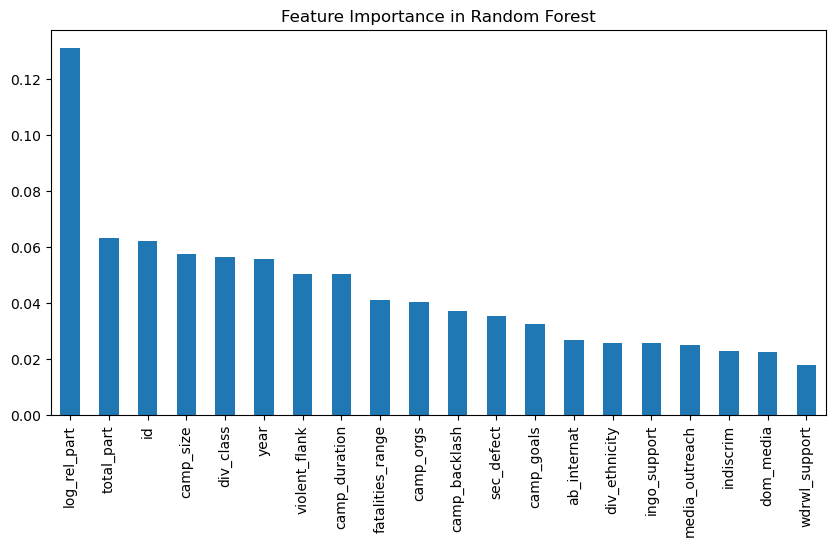

In [48]:
# Get feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X_train_fs.columns).sort_values(ascending=False)

# Plot top 20
plt.figure(figsize=(10,5))
feature_importances[:20].plot(kind="bar")
plt.title("Feature Importance in Random Forest")
plt.show()

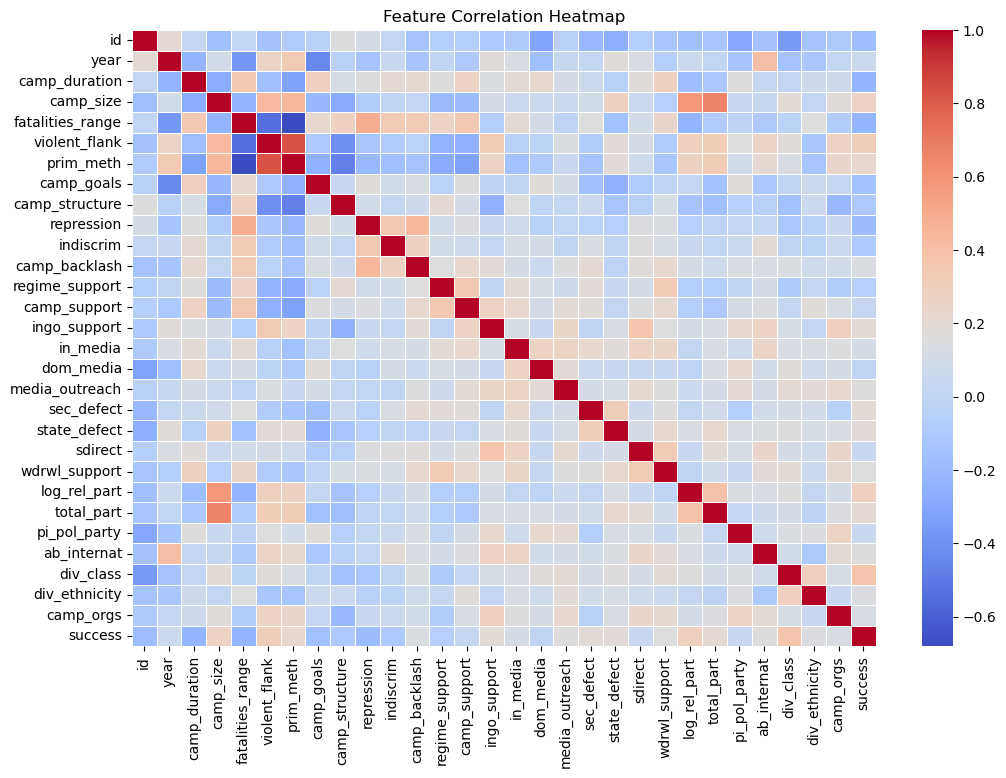

In [49]:
# Feature Colinearity Correlation Heatmap
df_corr = X_train_fs.copy()
df_corr["success"] = y_train_fs

plt.figure(figsize=(12,8))
sns.heatmap(df_corr.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [50]:
# 1. Compute correlation matrix
corr_matrix = df_corr.corr()

# 2. Unstack into pairs
corr_pairs = corr_matrix.unstack()

# 3. Convert to DataFrame and drop duplicate/self pairs
corr_df = corr_pairs.reset_index()
corr_df.columns = ['Feature_1', 'Feature_2', 'Correlation']

# 4. Drop self-correlations (i.e., correlation = 1)
corr_df = corr_df[corr_df["Feature_1"] != corr_df["Feature_2"]]

# 5. Filter for strong correlations
strong_corr = corr_df[abs(corr_df["Correlation"]) > 0.4]

# 6. Optional: Drop duplicate pairs (A-B and B-A)
strong_corr = strong_corr.drop_duplicates(subset=["Correlation"])

# 7. Sort by strength
strong_corr_sorted = strong_corr.sort_values(by="Correlation", ascending=False)

# 8. Display
print(strong_corr_sorted)

# A good deal of colearity -- Tree Based Model Preferred

            Feature_1       Feature_2  Correlation
156     violent_flank       prim_meth     0.825985
113         camp_size      total_part     0.668041
112         camp_size    log_rel_part     0.587576
129  fatalities_range      repression     0.491888
96          camp_size       prim_meth     0.447075
281        repression   camp_backlash     0.438226
95          camp_size   violent_flank     0.424218
55               year     ab_internat     0.407805
158     violent_flank  camp_structure    -0.410544
37               year      camp_goals    -0.442569
188         prim_meth  camp_structure    -0.473930
125  fatalities_range   violent_flank    -0.539981
126  fatalities_range       prim_meth    -0.680868


In [51]:
# Looks like a non-linear relationship

In [52]:
# Eliminate similar features
df1_fs = df1_fs.drop(columns=['id', 'camp_size'])

In [53]:
# TRAIN TEST SPLIT FOR RANDOM FOREST MODEL FINAL ---------------------------------------------------------------------------------------

In [54]:
# Dealing with Imbalanced Data: Balanced Classes
# Storage for metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

X = df1_fs.drop(columns=['success'])
y = df1_fs['success']
# Seeds to test
seeds = [1, 42, 99, 2024, 77]

# Loop through seeds
for seed in seeds:
    # Train/test split
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # Fresh model with tuned hyperparameters
    rf_2 = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=seed
    )
    rf_2.fit(X_train_rf, y_train_rf)
    
    # Predictions
    y_pred_rf = rf_2.predict(X_test_rf)
    y_prob_rf = rf_2.predict_proba(X_test_rf)[:, 1]

    # Metrics
    accuracies.append(accuracy_score(y_test_rf, y_pred_rf))
    precisions.append(precision_score(y_test_rf, y_pred_rf))
    recalls.append(recall_score(y_test_rf, y_pred_rf))
    f1_scores.append(f1_score(y_test_rf, y_pred_rf))
    roc_aucs.append(roc_auc_score(y_test_rf, y_prob_rf))

# Summary output
print("Random Forest Performance Across Splits:")
print(f"Accuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"ROC AUC:   {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")


Random Forest Performance Across Splits:
Accuracy:  0.7456 ± 0.0229
Precision: 0.6816 ± 0.0466
Recall:    0.6236 ± 0.0373
F1 Score:  0.6500 ± 0.0288
ROC AUC:   0.8293 ± 0.0297


In [55]:
# Dealing with Imbalanced Classes: Balanced Classes
# Storage for metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

X = df1_fs.drop(columns=['success'])
y = df1_fs['success']

# Seeds to test
seeds = [1, 42, 99, 2024, 77]

# Loop through seeds
for seed in seeds:
    # Train/test split
    X_train_unresampled, X_test_rf, y_train_unresampled, y_test_rf = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=seed)
    X_train_rf, y_train_rf = smote.fit_resample(X_train_unresampled, y_train_unresampled)
    
    # Fresh model with tuned hyperparameters
    rf_2 = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=seed
    )
    rf_2.fit(X_train_rf, y_train_rf)
    
    # Predictions
    y_pred_rf = rf_2.predict(X_test_rf)
    y_prob_rf = rf_2.predict_proba(X_test_rf)[:, 1]

    # Metrics
    accuracies.append(accuracy_score(y_test_rf, y_pred_rf))
    precisions.append(precision_score(y_test_rf, y_pred_rf))
    recalls.append(recall_score(y_test_rf, y_pred_rf))
    f1_scores.append(f1_score(y_test_rf, y_pred_rf))
    roc_aucs.append(roc_auc_score(y_test_rf, y_prob_rf))

# Summary output
print("Random Forest Performance Across Splits: SMOTE")
print(f"Accuracy:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"ROC AUC:   {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")


Random Forest Performance Across Splits: SMOTE
Accuracy:  0.7544 ± 0.0175
Precision: 0.6896 ± 0.0555
Recall:    0.6530 ± 0.0448
F1 Score:  0.6679 ± 0.0220
ROC AUC:   0.8305 ± 0.0289


/opt/anaconda3/envs/rf_project_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


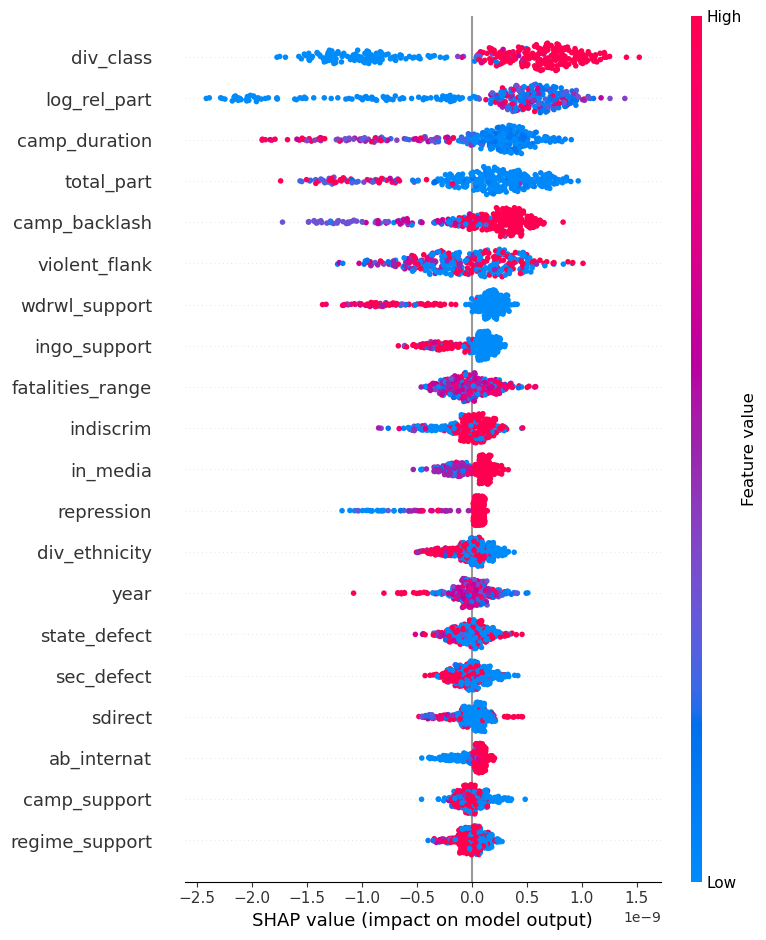

In [56]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_2, X_train_rf)
shap_values = explainer(X_train_rf)

#print(type(shap_values))
#print(len(shap_values) if isinstance(shap_values, list) else shap_values.shape)

shap_values_array = shap_values.values  # Extract array


shap.summary_plot(shap_values_array.mean(2), X_train_rf)

# Summary plot (shows overall feature importance & direction)
#shap.summary_plot(shap_values, X_train_fs_df)


In [57]:
# SHAP Feature Select
# Compute mean absolute SHAP values
feature_importance = np.abs(shap_values.values).mean(axis=0) 
feature_importance_df_rf = pd.DataFrame({"Feature": X_train_rf.columns, "Importance": feature_importance.mean(axis=1)})

# Sort by importance
feature_importance_df_rf = feature_importance_df_rf.sort_values(by="Importance", ascending=False)

# Display feature importance
print(feature_importance_df_rf)


             Feature  Importance
24         div_class    0.059286
3      violent_flank    0.053294
20      log_rel_part    0.053228
21        total_part    0.050026
9      camp_backlash    0.042019
1      camp_duration    0.031970
19     wdrwl_support    0.023607
2   fatalities_range    0.023600
8          indiscrim    0.021839
16        sec_defect    0.017448
0               year    0.016978
25     div_ethnicity    0.016504
17      state_defect    0.013834
18           sdirect    0.013166
12      ingo_support    0.011831
5         camp_goals    0.008426
11      camp_support    0.007962
10    regime_support    0.007881
15    media_outreach    0.007655
6     camp_structure    0.007266
26         camp_orgs    0.006957
7         repression    0.006752
23       ab_internat    0.006494
22      pi_pol_party    0.005556
14         dom_media    0.005144
4          prim_meth    0.004776
13          in_media    0.004547


In [58]:
# Select top 20 most important features
top_n = 21
top_features = feature_importance_df_rf.head(top_n)["Feature"].tolist()

# Filter dataset
X_train_filtered = X_train_rf[top_features]
X_test_filtered = X_test_rf[top_features]

print(X_train_filtered.columns)

Index(['div_class', 'violent_flank', 'log_rel_part', 'total_part',
       'camp_backlash', 'camp_duration', 'wdrwl_support', 'fatalities_range',
       'indiscrim', 'sec_defect', 'year', 'div_ethnicity', 'state_defect',
       'sdirect', 'ingo_support', 'camp_goals', 'camp_support',
       'regime_support', 'media_outreach', 'camp_structure', 'camp_orgs'],
      dtype='object')


In [59]:
# Random Forest Feature Importance
# Extract feature importance from a trained Random Forest model
importances = rf_2.feature_importances_
rf_feature_importance_df = pd.DataFrame({"Feature": X_train_rf.columns, "Importance": importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by="Importance", ascending=False)

# Keep only the top 20 features
top_rf_features = rf_feature_importance_df.head(21)["Feature"].tolist()
X_train_filtered_rf = X_train_rf[top_rf_features]

print(X_train_filtered_rf.columns)


Index(['log_rel_part', 'total_part', 'div_class', 'violent_flank', 'year',
       'camp_duration', 'camp_backlash', 'fatalities_range', 'camp_orgs',
       'wdrwl_support', 'indiscrim', 'state_defect', 'camp_goals',
       'sec_defect', 'sdirect', 'media_outreach', 'div_ethnicity',
       'camp_structure', 'dom_media', 'ingo_support', 'in_media'],
      dtype='object')


In [60]:
# Compare Features
common_features = list(set(X_train_filtered_rf.columns) & set(X_train_filtered.columns))
print("Common features:", common_features)


Common features: ['div_ethnicity', 'camp_structure', 'sdirect', 'violent_flank', 'sec_defect', 'ingo_support', 'wdrwl_support', 'indiscrim', 'log_rel_part', 'year', 'div_class', 'total_part', 'state_defect', 'camp_backlash', 'camp_goals', 'fatalities_range', 'camp_duration', 'media_outreach', 'camp_orgs']


In [61]:
# Diff Features
only_in_rf = list(set(X_train_filtered_rf.columns) - set(X_train_filtered.columns))
print("Features only in rf:", only_in_rf)

only_in_shap = list(set(X_train_filtered) - set(X_train_filtered_rf))
print("Features only in SHAP:", only_in_shap)

Features only in rf: ['dom_media', 'in_media']
Features only in SHAP: ['regime_support', 'camp_support']


In [62]:
# SHAP feature importance
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({"Feature": X_train_rf.columns, "SHAP Importance": shap_importance.mean(axis=1)})

# Random Forest feature importance
rf_importance_df = pd.DataFrame({"Feature": X_train_rf.columns, "RF Importance": rf_2.feature_importances_})

# Merge and compare
importance_comparison = shap_importance_df.merge(rf_importance_df, on="Feature").sort_values(by="SHAP Importance", ascending=False)
print(importance_comparison)


             Feature  SHAP Importance  RF Importance
24         div_class         0.059286       0.088767
3      violent_flank         0.053294       0.077663
20      log_rel_part         0.053228       0.110066
21        total_part         0.050026       0.105235
9      camp_backlash         0.042019       0.052403
1      camp_duration         0.031970       0.060209
19     wdrwl_support         0.023607       0.032961
2   fatalities_range         0.023600       0.043920
8          indiscrim         0.021839       0.030164
16        sec_defect         0.017448       0.023980
0               year         0.016978       0.065765
25     div_ethnicity         0.016504       0.020318
17      state_defect         0.013834       0.029668
18           sdirect         0.013166       0.021671
12      ingo_support         0.011831       0.017653
5         camp_goals         0.008426       0.029379
11      camp_support         0.007962       0.013205
10    regime_support         0.007881       0.

In [63]:
# NEW FILTERED DATA RANDOM FOREST MODEL --------------------------------------------------------------------------------------------------

In [64]:
from imblearn.over_sampling import SMOTE

# Storage for metrics
accuracies_wy = []
precisions_wy = []
recalls_wy = []
f1_scores_wy = []
roc_aucs_wy = []

X_filtered = X[top_features]  # Assume 'X' and 'top_features' are already defined

# Try multiple seeds
seeds = [1, 42, 99, 2024, 77]

for seed in seeds:
    # Split filtered data
    X_train_unresampled, X_test_rf_filtered, y_train_unresampled, y_test_rf = train_test_split(
        X_filtered, y, test_size=0.3, random_state=seed
    )
    
    # Apply SMOTE to training set
    smote = SMOTE(random_state=seed)
    X_train_rf_filtered, y_train_rf = smote.fit_resample(X_train_unresampled, y_train_unresampled)

    # Train a new RF model with the current seed
    rf_shap = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
    rf_shap.fit(X_train_rf_filtered, y_train_rf)

    # Predictions
    y_pred_rf = rf_shap.predict(X_test_rf_filtered)
    y_pred_prob_rf = rf_shap.predict_proba(X_test_rf_filtered)[:, 1]

    # Metrics
    accuracies_wy.append(accuracy_score(y_test_rf, y_pred_rf))
    precisions_wy.append(precision_score(y_test_rf, y_pred_rf))
    recalls_wy.append(recall_score(y_test_rf, y_pred_rf))
    f1_scores_wy.append(f1_score(y_test_rf, y_pred_rf))
    roc_aucs_wy.append(roc_auc_score(y_test_rf, y_pred_prob_rf))

# Summary of results
print("Random Forest (SHAP-selected features) Performance Across Splits: SMOTE")
print(f"Accuracy:  {np.mean(accuracies_wy):.4f} ± {np.std(accuracies_wy):.4f}")
print(f"Precision: {np.mean(precisions_wy):.4f} ± {np.std(precisions_wy):.4f}")
print(f"Recall:    {np.mean(recalls_wy):.4f} ± {np.std(recalls_wy):.4f}")
print(f"F1 Score:  {np.mean(f1_scores_wy):.4f} ± {np.std(f1_scores_wy):.4f}")
print(f"ROC AUC:   {np.mean(roc_aucs_wy):.4f} ± {np.std(roc_aucs_wy):.4f}")


Random Forest (SHAP-selected features) Performance Across Splits: SMOTE
Accuracy:  0.7596 ± 0.0275
Precision: 0.6982 ± 0.0522
Recall:    0.6576 ± 0.0337
F1 Score:  0.6754 ± 0.0225
ROC AUC:   0.8349 ± 0.0350


In [65]:
print(y_train_rf.value_counts())
print(y_train_rf.value_counts(normalize=True))

print(y_test_rf.value_counts())
print(y_test_rf.value_counts(normalize=True))


success
0    163
1    163
Name: count, dtype: int64
success
0    0.5
1    0.5
Name: proportion, dtype: float64
success
0    71
1    43
Name: count, dtype: int64
success
0    0.622807
1    0.377193
Name: proportion, dtype: float64


In [66]:
# Dealing with Imbalanced Data: Balanced Classes
# Storage for metrics
accuracies_wy = []
precisions_wy = []
recalls_wy = []
f1_scores_wy = []
roc_aucs_wy = []

X_filtered = X[top_features]

# Try multiple seeds
seeds = [1, 42, 99, 2024, 77]

for seed in seeds:
    # Split filtered data
    X_train_rf_filtered, X_test_rf_filtered, y_train_rf, y_test_rf = train_test_split(
        X_filtered, y, test_size=0.3, random_state=seed
    )
    
    # Train a new RF model with the current seed
    rf_shap = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
    rf_shap.fit(X_train_rf_filtered, y_train_rf)

    # Predictions
    y_pred_rf = rf_shap.predict(X_test_rf_filtered)
    y_pred_prob_rf = rf_shap.predict_proba(X_test_rf_filtered)[:, 1]

    # Metrics
    accuracies_wy.append(accuracy_score(y_test_rf, y_pred_rf))
    precisions_wy.append(precision_score(y_test_rf, y_pred_rf))
    recalls_wy.append(recall_score(y_test_rf, y_pred_rf))
    f1_scores_wy.append(f1_score(y_test_rf, y_pred_rf))
    roc_aucs_wy.append(roc_auc_score(y_test_rf, y_pred_prob_rf))

# Summary of results
print("Random Forest (SHAP-selected features) Performance Across Splits: BC")
print(f"Accuracy:  {np.mean(accuracies_wy):.4f} ± {np.std(accuracies_wy):.4f}")
print(f"Precision: {np.mean(precisions_wy):.4f} ± {np.std(precisions_wy):.4f}")
print(f"Recall:    {np.mean(recalls_wy):.4f} ± {np.std(recalls_wy):.4f}")
print(f"F1 Score:  {np.mean(f1_scores_wy):.4f} ± {np.std(f1_scores_wy):.4f}")
print(f"ROC AUC:   {np.mean(roc_aucs_wy):.4f} ± {np.std(roc_aucs_wy):.4f}")

Random Forest (SHAP-selected features) Performance Across Splits: BC
Accuracy:  0.7667 ± 0.0358
Precision: 0.7358 ± 0.0369
Recall:    0.6071 ± 0.0575
F1 Score:  0.6641 ± 0.0429
ROC AUC:   0.8402 ± 0.0382


In [67]:
# Dealing with Imbalanced Data: Balanced Classes
# Drop 'year' from the full dataset
X_noyear = X_filtered.drop(columns=['year'])

# Storage for metrics
accuracies_ny = []
precisions_ny = []
recalls_ny = []
f1_scores_ny = []
roc_aucs_ny = []

# Try multiple random seeds for robustness
seeds = [1, 42, 99, 2024, 77]

for seed in seeds:
    # Split data (unresampled)
    X_train_unresampled, X_test_ny, y_train_unresampled, y_test_ny = train_test_split(
        X_noyear, y, test_size=0.3, random_state=seed
    )

    # Apply SMOTE to training set
    smote = SMOTE(random_state=seed)
    X_train_ny, y_train_ny = smote.fit_resample(X_train_unresampled, y_train_unresampled)

    # Train new model with each split
    rf_shap = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
    rf_shap.fit(X_train_ny, y_train_ny)

    # Predict
    y_pred = rf_shap.predict(X_test_ny)
    y_prob = rf_shap.predict_proba(X_test_ny)[:, 1]

    # Evaluate
    accuracies_ny.append(accuracy_score(y_test_ny, y_pred))
    precisions_ny.append(precision_score(y_test_ny, y_pred))
    recalls_ny.append(recall_score(y_test_ny, y_pred))
    f1_scores_ny.append(f1_score(y_test_ny, y_pred))
    roc_aucs_ny.append(roc_auc_score(y_test_ny, y_prob))

# Print averaged metrics
print("Random Forest (no 'year') Performance Across Splits: SMOTE")
print(f"Accuracy:  {np.mean(accuracies_ny):.4f} ± {np.std(accuracies_ny):.4f}")
print(f"Precision: {np.mean(precisions_ny):.4f} ± {np.std(precisions_ny):.4f}")
print(f"Recall:    {np.mean(recalls_ny):.4f} ± {np.std(recalls_ny):.4f}")
print(f"F1 Score:  {np.mean(f1_scores_ny):.4f} ± {np.std(f1_scores_ny):.4f}")
print(f"ROC AUC:   {np.mean(roc_aucs_ny):.4f} ± {np.std(roc_aucs_ny):.4f}")


Random Forest (no 'year') Performance Across Splits: SMOTE
Accuracy:  0.7684 ± 0.0302
Precision: 0.7005 ± 0.0475
Recall:    0.6796 ± 0.0896
F1 Score:  0.6869 ± 0.0589
ROC AUC:   0.8371 ± 0.0298


In [68]:
# Compare year and no year

In [69]:
# Example for with 'year'
rf_with_year_results = {
    "Accuracy": accuracies_wy,
    "Precision": precisions_wy,
    "Recall": recalls_wy,
    "F1 Score": f1_scores_wy,
    "ROC AUC": roc_aucs_wy
}
# Example for without 'year'
rf_without_year_results = {
    "Accuracy": accuracies_ny,
    "Precision": precisions_ny,
    "Recall": recalls_ny,
    "F1 Score": f1_scores_ny,
    "ROC AUC": roc_aucs_ny
}

In [70]:
# Create comparison dataframe from real metrics
metrics = list(rf_with_year_results.keys())

comparison_df = pd.DataFrame(index=metrics)

# Populate the comparison table
for metric in metrics:
    with_vals = rf_with_year_results[metric]
    without_vals = rf_without_year_results[metric]
    
    mean_with = np.mean(with_vals)
    std_with = np.std(with_vals)
    
    mean_without = np.mean(without_vals)
    std_without = np.std(without_vals)
    
    comparison_df.loc[metric, "With Year (Mean ± Std)"] = f"{mean_with:.4f} ± {std_with:.4f}"
    comparison_df.loc[metric, "Without Year (Mean ± Std)"] = f"{mean_without:.4f} ± {std_without:.4f}"
    comparison_df.loc[metric, "Difference (With − Without)"] = f"{mean_with - mean_without:+.4f}"

print(comparison_df)

#Looks like it is more helpful to exclude Year

          With Year (Mean ± Std) Without Year (Mean ± Std)  \
Accuracy         0.7667 ± 0.0358           0.7684 ± 0.0302   
Precision        0.7358 ± 0.0369           0.7005 ± 0.0475   
Recall           0.6071 ± 0.0575           0.6796 ± 0.0896   
F1 Score         0.6641 ± 0.0429           0.6869 ± 0.0589   
ROC AUC          0.8402 ± 0.0382           0.8371 ± 0.0298   

          Difference (With − Without)  
Accuracy                      -0.0018  
Precision                     +0.0353  
Recall                        -0.0725  
F1 Score                      -0.0228  
ROC AUC                       +0.0031  


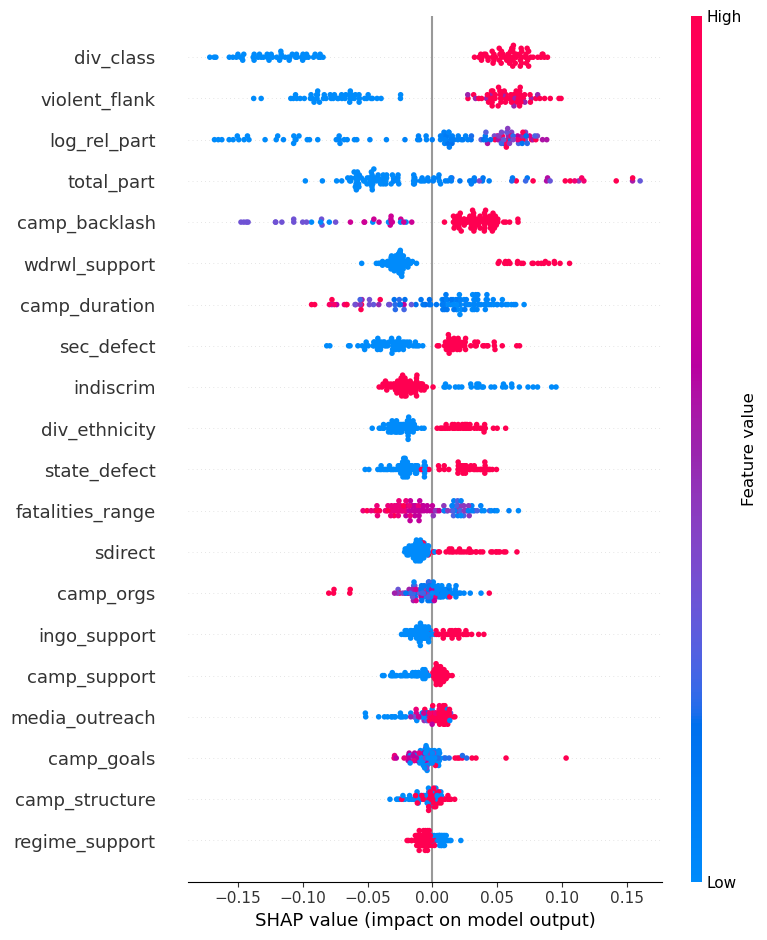

In [71]:
# New Shap Feature Importance 

# Create a SHAP explainer for the new model
explainer = shap.TreeExplainer(rf_shap)  # Use the new Random Forest model trained with selected features

# Compute SHAP values for the filtered test set
shap_values_new = explainer.shap_values(X_test_ny, check_additivity=False)

shap.summary_plot(shap_values_new[..., 1], X_test_ny)


In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
# HYPERTUNING -------------------------------------------------------------------------------------------------------------

In [73]:
param_grid = {
    'n_estimators': [100, 200],            # number of trees
    'max_depth': [None, 10, 20],           # tree depth
    'min_samples_split': [2, 5],           # min samples to split a node
    'min_samples_leaf': [1, 2],            # min samples at a leaf
    'class_weight': ['balanced']           # handle class imbalance
}


In [74]:
rf_3 = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_3,
    param_grid=param_grid,
    scoring='recall',     # or 'f1', 'roc_auc', depending on your goal
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # use all CPU cores
    verbose=2             # show progress
)


In [75]:
grid_search.fit(X_train_ny, y_train_ny)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2)

In [76]:
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Predict using best model
y_pred = best_rf.predict(X_test_ny)
y_pred_prob = best_rf.predict_proba(X_test_ny)[:, 1]


Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [77]:
# Define the tuned Random Forest model
rf_shap_tuned = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Train on SHAP-filtered, year-dropped training data
rf_shap_tuned.fit(X_train_ny, y_train_ny)

# Predict on SHAP-filtered, year-dropped test data
y_pred = rf_shap_tuned.predict(X_test_ny)
y_pred_prob = rf_shap_tuned.predict_proba(X_test_ny)[:, 1]

# Evaluate
accuracy_rf = accuracy_score(y_test_ny, y_pred)
precision_rf = precision_score(y_test_ny, y_pred)
recall_rf = recall_score(y_test_ny, y_pred)
f1_rf = f1_score(y_test_ny, y_pred)
roc_auc_rf = roc_auc_score(y_test_ny, y_pred_prob)

# Print results
print(f"Tuned Random Forest (SHAP-selected, no 'year', SMOTE) Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")


Tuned Random Forest (SHAP-selected, no 'year', SMOTE) Performance:
Accuracy: 0.7544
Precision: 0.6531
Recall: 0.7442
F1-score: 0.6957
ROC-AUC Score: 0.7972


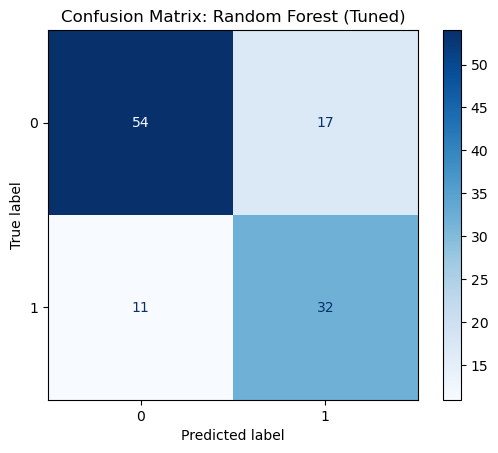

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(y_test_ny, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_shap_tuned.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix: Random Forest (Tuned)")
plt.show()


In [79]:
# Compute mean absolute SHAP importance
shap_importance_new = np.abs(shap_values_new).mean(axis=0)

# Create a DataFrame of SHAP importance
shap_importance_df_new = pd.DataFrame({
    "Feature": X_test_ny.columns,
    "SHAP Importance": shap_importance_new.mean(axis=1)
}).sort_values(by="SHAP Importance", ascending=False)

shap_importance_df_new.reset_index(drop=True, inplace=True)

# Display feature rankings
print(shap_importance_df_new)


             Feature  SHAP Importance
0          div_class         0.087065
1      violent_flank         0.065982
2       log_rel_part         0.061005
3         total_part         0.047823
4      camp_backlash         0.046227
5      wdrwl_support         0.036375
6      camp_duration         0.034323
7         sec_defect         0.029782
8          indiscrim         0.026412
9      div_ethnicity         0.024329
10      state_defect         0.023453
11  fatalities_range         0.023319
12           sdirect         0.016422
13         camp_orgs         0.013102
14      ingo_support         0.011948
15      camp_support         0.010407
16    media_outreach         0.010169
17        camp_goals         0.009908
18    camp_structure         0.007314
19    regime_support         0.007127


In [80]:
# Compute mean absolute SHAP importance
shap_importance_new = np.abs(shap_values_new).mean(axis=0)

# Create a DataFrame of SHAP importance
shap_importance_df_new = pd.DataFrame({
    "Feature": X_test_ny.columns,
    "SHAP Importance": shap_importance_new.mean(axis=1)
}).sort_values(by="SHAP Importance", ascending=False)

shap_importance_df_new.reset_index(drop=True, inplace=True)

# Display feature rankings
print(shap_importance_df_new)

             Feature  SHAP Importance
0          div_class         0.087065
1      violent_flank         0.065982
2       log_rel_part         0.061005
3         total_part         0.047823
4      camp_backlash         0.046227
5      wdrwl_support         0.036375
6      camp_duration         0.034323
7         sec_defect         0.029782
8          indiscrim         0.026412
9      div_ethnicity         0.024329
10      state_defect         0.023453
11  fatalities_range         0.023319
12           sdirect         0.016422
13         camp_orgs         0.013102
14      ingo_support         0.011948
15      camp_support         0.010407
16    media_outreach         0.010169
17        camp_goals         0.009908
18    camp_structure         0.007314
19    regime_support         0.007127


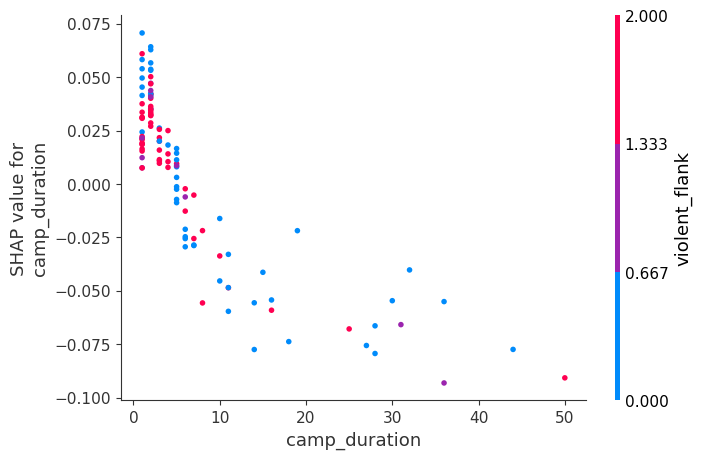

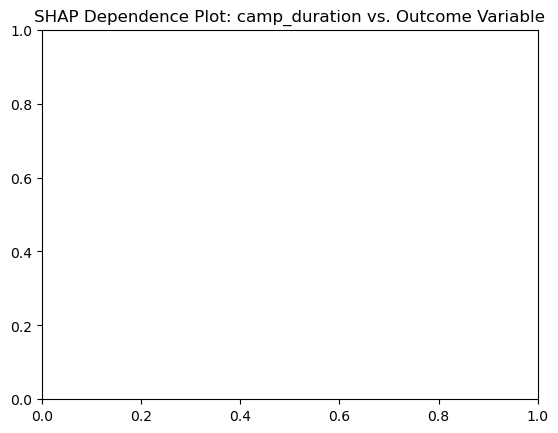

In [81]:
# Ensure you have SHAP values for Class 1 (if it's a classification model)
shap_values_for_class_1 = shap_values_new[..., 1] if shap_values_new.ndim == 3 else shap_values_new

# Choose the feature you want to analyze
feature_name = "camp_duration"  # Change this to the feature you want to compare

# Generate the dependence plot
shap.dependence_plot(feature_name, shap_values_for_class_1, X_test_ny)

plt.title(f"SHAP Dependence Plot: {feature_name} vs. Outcome Variable")
plt.show()


In [82]:
#shap.dependence_plot("camp_duration", shap_values_new[..., 1], X_test_filtered, interaction_index="")

             Feature  RF Importance
2       log_rel_part       0.123444
3         total_part       0.117693
0          div_class       0.095233
1      violent_flank       0.085317
5      camp_duration       0.069881
4      camp_backlash       0.062033
7   fatalities_range       0.054223
19         camp_orgs       0.052419
9         sec_defect       0.038942
14        camp_goals       0.038637
8          indiscrim       0.037911
6      wdrwl_support       0.036729
11      state_defect       0.031596
17    media_outreach       0.031245
10     div_ethnicity       0.028381
12           sdirect       0.022882
18    camp_structure       0.022819
15      camp_support       0.018994
13      ingo_support       0.016585
16    regime_support       0.015035


/var/folders/4m/ht0t5jqs2vd2vkb4nhj9592c0000gn/T/ipykernel_43956/483128887.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importance_df["RF Importance"], y=rf_importance_df["Feature"], palette="viridis")


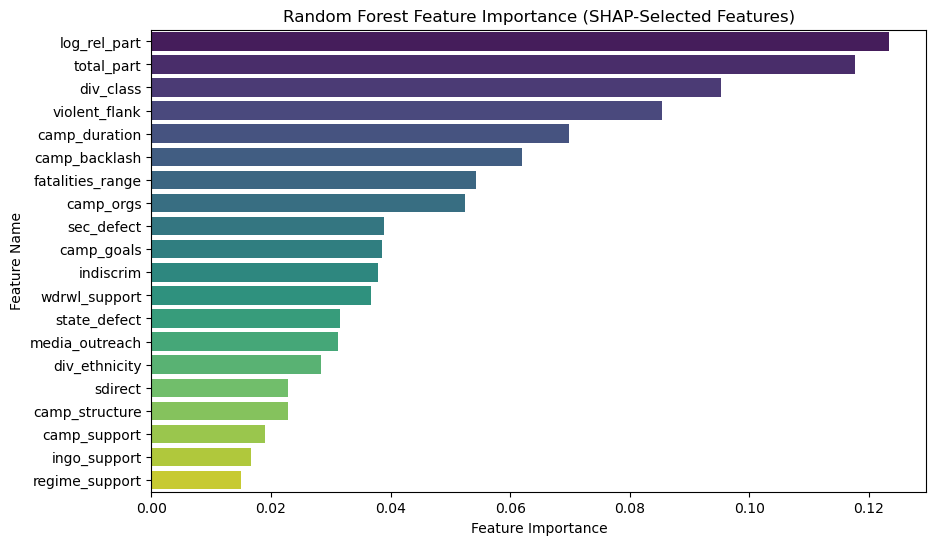

In [83]:
#RF Feature Importance
# Extract feature importance from the trained Random Forest model (rf_shap)
rf_importance_df = pd.DataFrame({
    "Feature": X_train_ny.columns,
    "RF Importance": rf_shap.feature_importances_
}).sort_values(by="RF Importance", ascending=False)

# Display the DataFrame with feature importance values
print(rf_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importance_df["RF Importance"], y=rf_importance_df["Feature"], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Random Forest Feature Importance (SHAP-Selected Features)")
plt.show()


In [84]:
# LOGISTIC REGRESSION -------------------------------------------------------------------------------------------------------------

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd


# Define and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=500, random_state=42, class_weight="balanced")
log_reg.fit(X_train_ny, y_train_ny)

# Set a custom threshold
custom_threshold = 0.5  # Try 0.3, 0.5, etc. to tune precision vs. recall

# Predict using the threshold
y_pred_custom = (y_pred_prob >= custom_threshold).astype(int)

y_pred_prob_custom = (log_reg.predict_proba(X_test_ny)[:, 1] >= custom_threshold).astype(int)

# Evaluate Model Performance
accuracy_lr = accuracy_score(y_test_ny, y_pred_custom)
precision_lr = precision_score(y_test_ny, y_pred_custom)
recall_lr = recall_score(y_test_ny, y_pred_custom)
f1_lr = f1_score(y_test_ny, y_pred_custom)
roc_auc_lr = roc_auc_score(y_test_ny, y_pred_prob_custom)

# Print Results
print(f"Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print(f"ROC-AUC Score: {roc_auc_lr:.4f}")

# Get feature coefficients
feature_importance_df = pd.DataFrame({
    "Feature": X_train_ny.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

# Display feature importance
print("\nFeature Coefficients:")
print(feature_importance_df)


Logistic Regression Model Performance:
Accuracy: 0.7544
Precision: 0.6531
Recall: 0.7442
F1-score: 0.6957
ROC-AUC Score: 0.6823

Feature Coefficients:
             Feature   Coefficient
6      wdrwl_support  1.221302e+00
0          div_class  1.138708e+00
9         sec_defect  7.804963e-01
10     div_ethnicity  6.257418e-01
12           sdirect  6.065221e-01
4      camp_backlash  4.784377e-01
11      state_defect  4.690685e-01
13      ingo_support  2.779753e-01
15      camp_support  1.952382e-01
17    media_outreach  1.018852e-01
1      violent_flank  1.010082e-01
14        camp_goals  9.504177e-02
2       log_rel_part  5.989615e-03
19         camp_orgs  3.417439e-03
3         total_part -4.393942e-08
5      camp_duration -1.019010e-01
18    camp_structure -2.396740e-01
16    regime_support -2.961446e-01
7   fatalities_range -3.545374e-01
8          indiscrim -8.979377e-01


/opt/anaconda3/envs/rf_project_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


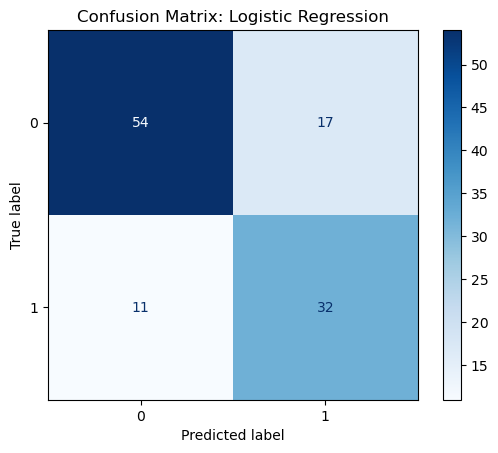

In [86]:
# Create the confusion matrix
cm = confusion_matrix(y_test_ny, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()


In [87]:
# Create a dictionary of metrics
metrics_comparison = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"],
    "Tuned Random Forest": [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf],
    "Logistic Regression": [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr],
    "Difference (RF - LR)": [
        accuracy_rf - accuracy_lr,
        precision_rf - precision_lr,
        recall_rf - recall_lr,
        f1_rf - f1_lr,
        roc_auc_rf - roc_auc_lr
    ]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(metrics_comparison)

# Format the columns
comparison_df["Tuned Random Forest"] = comparison_df["Tuned Random Forest"].apply(lambda x: f"{x:.4f}")
comparison_df["Logistic Regression"] = comparison_df["Logistic Regression"].apply(lambda x: f"{x:.4f}")
comparison_df["Difference (RF - LR)"] = comparison_df["Difference (RF - LR)"].apply(lambda x: f"{x:+.4f}")

print(comparison_df)

      Metric Tuned Random Forest Logistic Regression Difference (RF - LR)
0   Accuracy              0.7544              0.7544              +0.0000
1  Precision              0.6531              0.6531              +0.0000
2     Recall              0.7442              0.7442              +0.0000
3   F1-score              0.6957              0.6957              +0.0000
4    ROC-AUC              0.7972              0.6823              +0.1150


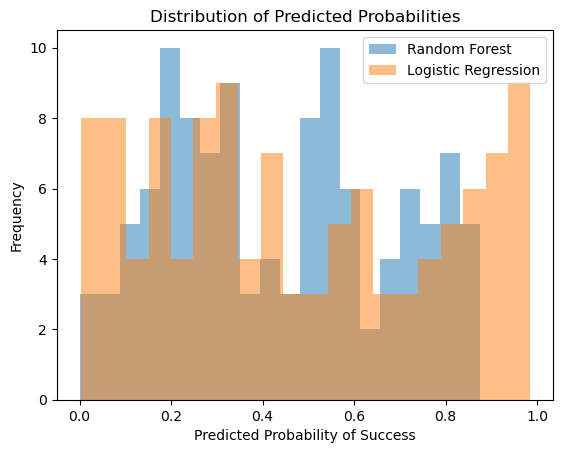

In [88]:
plt.hist(rf_shap_tuned.predict_proba(X_test_ny)[:, 1], bins=20, alpha=0.5, label='Random Forest')
plt.hist(log_reg.predict_proba(X_test_ny)[:, 1], bins=20, alpha=0.5, label='Logistic Regression')
plt.xlabel("Predicted Probability of Success")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.show()


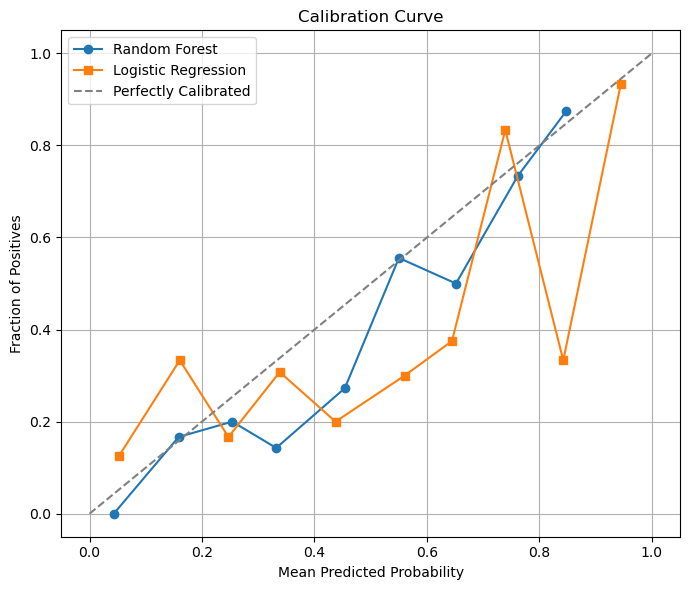

In [162]:
# Calibration Curve
from sklearn.calibration import calibration_curve

# Predicted probabilities (class 1 = success)
rf_probs = rf_shap_tuned.predict_proba(X_test_ny)[:, 1]
lr_probs = log_reg.predict_proba(X_test_ny)[:, 1]

# Get calibration data
prob_true_rf, prob_pred_rf = calibration_curve(y_test_rf, rf_probs, n_bins=10)
prob_true_lr, prob_pred_lr = calibration_curve(y_test_rf, lr_probs, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(7, 6))
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Random Forest')
plt.plot(prob_pred_lr, prob_true_lr, marker='s', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


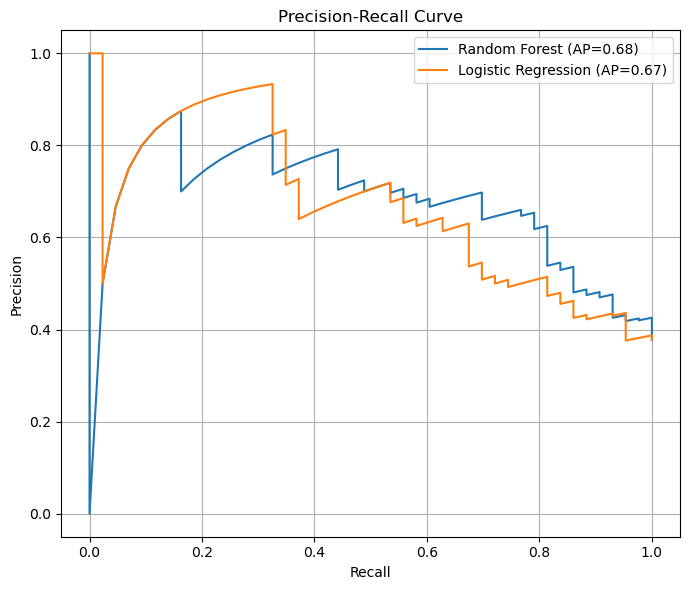

In [90]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision and recall
prec_rf, rec_rf, _ = precision_recall_curve(y_test_rf, rf_probs)
prec_lr, rec_lr, _ = precision_recall_curve(y_test_rf, lr_probs)

# Average precision (summary score)
ap_rf = average_precision_score(y_test_rf, rf_probs)
ap_lr = average_precision_score(y_test_rf, lr_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(7, 6))
plt.plot(rec_rf, prec_rf, label=f'Random Forest (AP={ap_rf:.2f})')
plt.plot(rec_lr, prec_lr, label=f'Logistic Regression (AP={ap_lr:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
# Check whether the actual predictions are the same
print((y_pred_rf == y_pred_custom).all()) 

# Check how different the probability scores are
print(np.allclose(y_pred_prob_rf, y_pred_prob_custom, atol=1e-5))

print(y_pred_prob_rf[:10])
print(y_pred_prob_custom[:10])

False
False
[0.71 0.89 0.07 0.14 0.19 0.23 0.78 0.79 0.34 0.36]
[1 1 0 0 0 0 1 1 0 0]


In [92]:
# Seems that Random Forest is slightly better 
# - ROC-AUC score is the main difference
# - RF has better probability spread
# - Better Calibrated Probability Estimates
# - RF has better recall levels overall

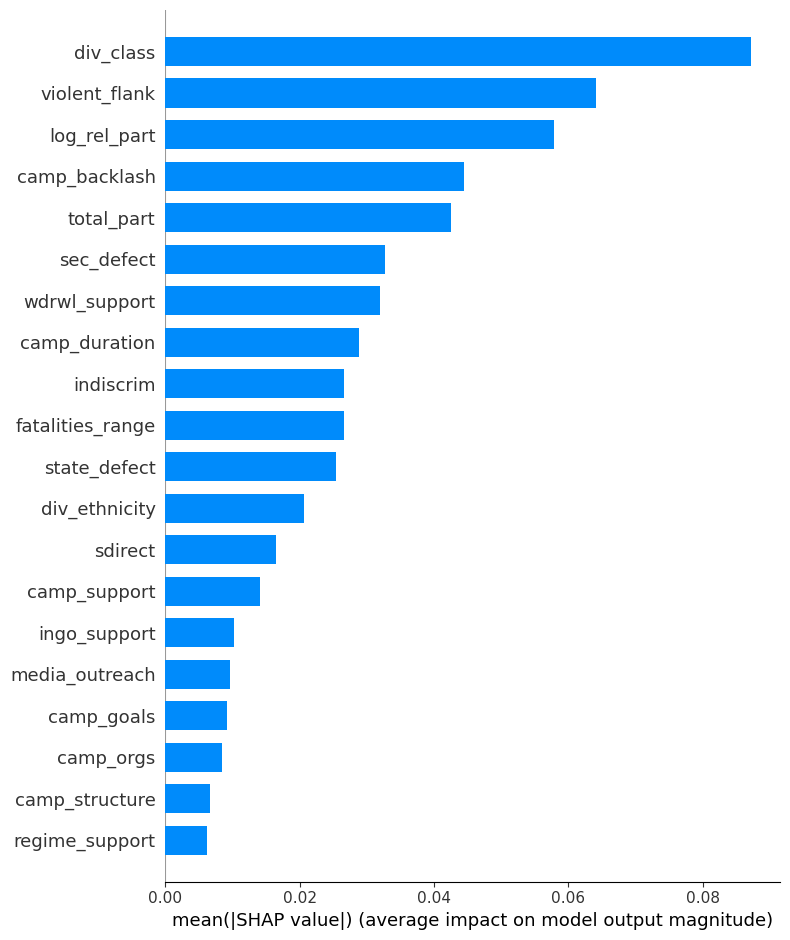

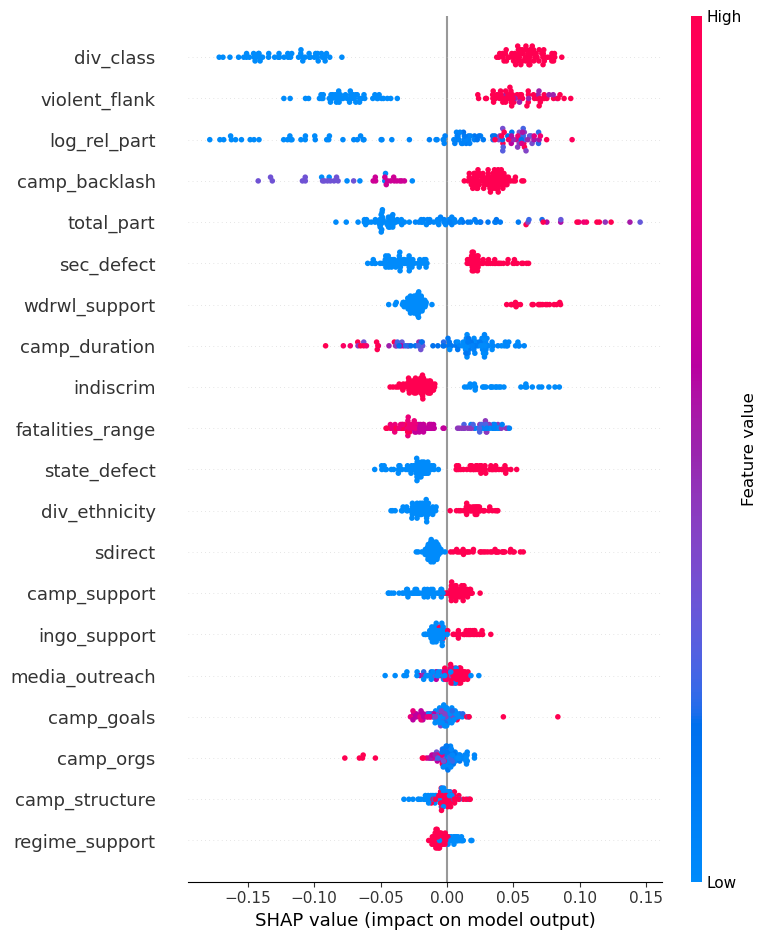

In [93]:
# Graphs for Poster
# Create SHAP explainer
explainer = shap.TreeExplainer(rf_shap_tuned)
shap_values = explainer.shap_values(X_test_ny)


# Summary plot
shap.summary_plot(shap_values[..., 1], X_test_ny, plot_type="bar")
shap.summary_plot(shap_values[..., 1], X_test_ny)  # Dot plot for direction + spread


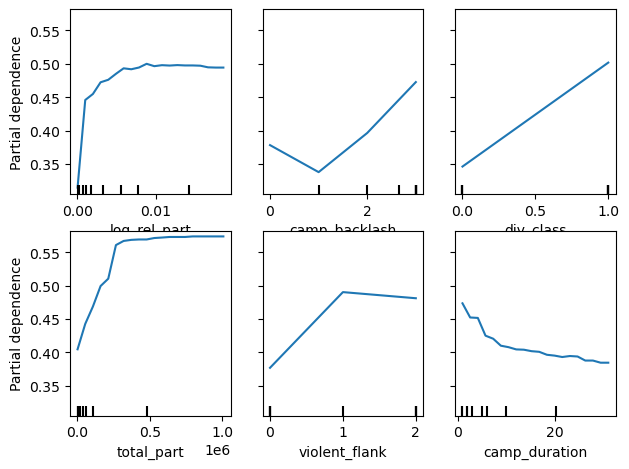

In [94]:
# Graph for Poster
from sklearn.inspection import PartialDependenceDisplay

# Plot PDP for selected features
features = ['log_rel_part', 'camp_backlash', 'div_class', 'total_part', 'violent_flank', 'camp_duration']

PartialDependenceDisplay.from_estimator(
    rf_shap_tuned,
    X_test_ny,
    features=features,
    kind="average",
    grid_resolution=20
)
plt.tight_layout()
plt.show()


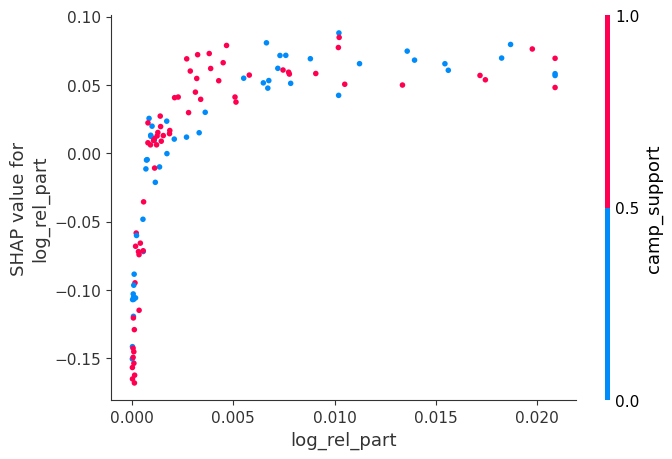

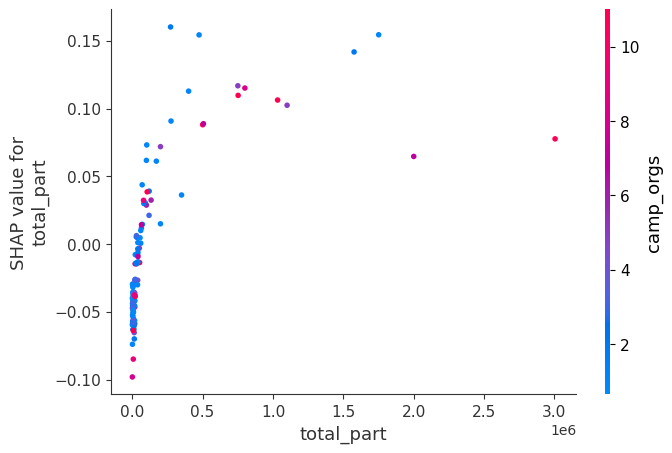

In [95]:
# Basic SHAP dependence plot
shap.dependence_plot("log_rel_part", shap_values_new[..., 1], X_test_ny)

# With interaction coloring
shap.dependence_plot("total_part", shap_values_new[..., 1], X_test_ny)


In [ ]:
# PREDICTION TESTS -------------------------------------------------------------------------------------------------------------

In [102]:
# Run a test predictio0n
# Map original input values to the updated SHAP-ranked feature names
sample_input = {
'wdrwl_support':1.250656e+00,
'div_class':1.034801e+00,
'sec_defect':7.589216e-01,
'sdirect':5.781821e-01,
'div_ethnicity':5.513224e-01,
'camp_backlash':4.608532e-01,
'state_defect':3.873066e-01,
'camp_support':2.261295e-01,
'violent_flank':2.094405e-01,
'camp_goals':1.306134e-01,
'ab_internat':6.398306e-02,
'log_rel_part':7.229054e-03,
'media_outreach':1.450923e-03,
'total_part':2.062547e-08,
'camp_orgs':-3.541489e-02,
'dom_media':-6.930089e-02,
'camp_duration':-9.874490e-02,
'regime_support':-2.694264e-01,
'fatalities_range':-2.925996e-01,
'indiscrim':-8.209170e-01,
'ingo_support': 0,
'camp_structure': 0
}


# Create DataFrame for prediction
sample_df = pd.DataFrame([sample_input])

print(rf_shap_tuned.feature_names_in_)
# Ensure sample_df columns match training data column order
sample_df = sample_df[rf_shap_tuned.feature_names_in_]

# Predict probability of campaign success using your trained model
prob = rf_shap_tuned.predict_proba(sample_df)[0, 1]

# Output the prediction
print(f"Predicted Probability of Success: {prob:.2%}")

['div_class' 'violent_flank' 'log_rel_part' 'total_part' 'camp_backlash'
 'camp_duration' 'wdrwl_support' 'fatalities_range' 'indiscrim'
 'sec_defect' 'div_ethnicity' 'state_defect' 'sdirect' 'ingo_support'
 'camp_goals' 'camp_support' 'regime_support' 'media_outreach'
 'camp_structure' 'camp_orgs']
Predicted Probability of Success: 76.20%


In [97]:
# probability function for UI
def predict_success_probability(user_input_dict, model, feature_order):
    """
    Predicts the probability of campaign success based on user input.
    
    Args:
        user_input_dict (dict): Dictionary of feature values from R Shiny UI.
        model: Trained sklearn model.
        feature_order (list): Ordered list of feature names expected by model.
    
    Returns:
        float: Probability of success (class 1).
    """
    # Create DataFrame with correct feature order
    feature_order = list(model.feature_names_in_)
    input_df = pd.DataFrame([user_input_dict])[feature_order]


    # Predict
    prob = model.predict_proba(input_df)[0, 1]
    return float(prob)

In [103]:
# Test Prediciton Function
predict_success_probability(sample_input, rf_shap_tuned,list(sample_input.keys())) 

0.7620119047619046

In [99]:
# Dependence Plot function for UI
def shap_dependence_plot(main_feature, interaction_feature, shap_values, X):
    """
    Generate a SHAP dependence plot with optional interaction coloring.
    """
    if interaction_feature == "None":
        interaction_feature = None

    shap.dependence_plot(
        main_feature,
        shap_values,
        X,
        interaction_index=interaction_feature,
        show=False  # So matplotlib doesn't auto-show in reticulate
    )
    plt.tight_layout()
    plt.show()


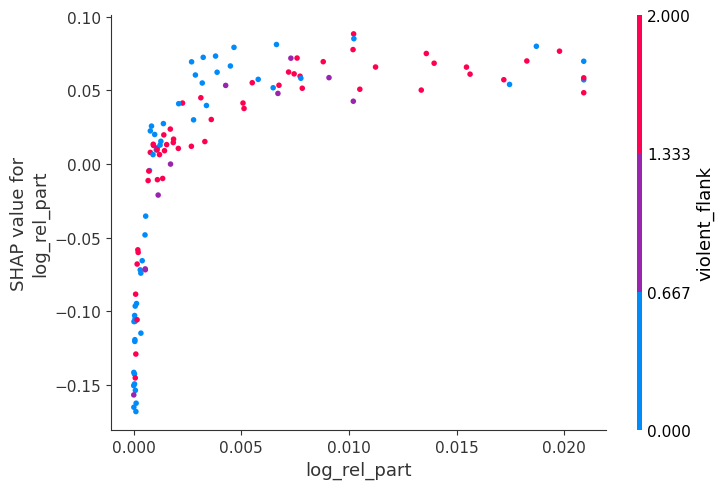

In [100]:
# Test Dependence Plot Function
shap_dependence_plot("log_rel_part","violent_flank",shap_values_new[...,1], X_test_ny)